In [119]:

# To embed plots in the notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd

import numpy as np # numpy library
import scipy . linalg as lng # linear algebra from scipy library
from scipy . spatial import distance # load distance function
from sklearn import preprocessing as preproc # load preprocessing function

#For ridge regression
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

#### Load dataset numpy

In [120]:
# Load the data from the CSV file                                 
data = np.genfromtxt('case1Data.csv', delimiter=',', skip_header=1,    
filling_values=np.nan)                                            


y = data[:, 0]
X = data[:, 1:]



[n, p] = X.shape

#Pandas dataframe
df = pd.read_csv("case1Data.csv")  # Replace with actual filename
df_new = pd.read_csv("case1Data_Xnew.csv")  # Replace with actual filename



#### Wrangling

In [ ]:

#Mode imputation for the categorical features
df.iloc[:, -5:] = df.iloc[:, -5:].apply(lambda col: col.fillna(col.mode()[0]))
df_new.iloc[:, -5:] = df_new.iloc[:, -5:].apply(lambda col: col.fillna(col.mode()[0]))

#Filling out the missing values in the numerical features with the mean
df.iloc[:, 1:-5] = df.iloc[:, 1:-5].apply(lambda col: col.fillna(col.mean()))

#One-hot encoding the categorical features
df = pd.get_dummies(df, columns=df.columns[-5:], dtype=int)

# Convert the numerical columns to float before applying standardization
df.iloc[:, :-36] = df.iloc[:, :-36].astype(float)



# Standardizing the numerical features and targets: z = (x - u) / sd
scaler = preproc.StandardScaler()
df.iloc[:, :-36] = scaler.fit_transform(df.iloc[:, :-36])


#Make target vector and fearture matrix

y = df.iloc[:, 0].to_numpy()
X = df.iloc[:, 1:].to_numpy()
#X = np.nan_to_num(X, nan=np.nanmean(X, axis=0))

[n, p] = X.shape



#### OLS

Bare OLS med off set

In [122]:
def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    
    return betas, res, rnk, s


# Include offset / intercept
off = np.ones(n) 
X = np.c_[off, X]


[n, p] = X.shape

#Split into train and test
X_train = X[:50, :]
X_test = X[50:, :]
y_train = y[:50]
y_test = y[50:]

#Estimate the model parameters
betas, residuals, rnk, s = ols_solver(X_train, y_train)

#Calculate y_hat
y_hat = X_test @ betas


res_solv_man = (y_test - y_hat) ** 2    
mse = np.mean(res_solv_man)


print(f'mse from lstsq: {mse}') # lng.lstsq returns sum of squared residuals, so we divide by num of obs to get mean
rss = np.sum(res_solv_man)
print(f'RSS: {rss}')
tss = np.sum((y - np.mean(y))** 2)
print(f'TSS: {tss}')
r2 = (1 - rss / tss) * 100
print(f'R2: {r2}')

mse from lstsq: 0.5744442099257671
RSS: 28.722210496288355
TSS: 100.0
R2: 71.27778950371165


#### Ridge regression

##### lamda range

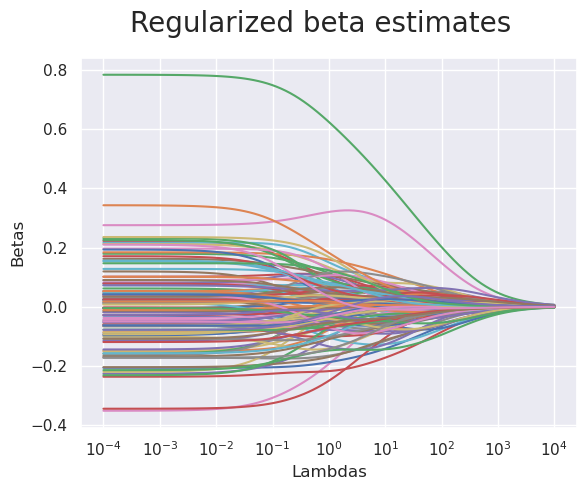

In [123]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas
k = 100; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))

for i in range(k):
    betas[:, i] = ridgeMulti(X, lambdas[i], p, y)
    
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=20)
plt.show()


In [124]:
# Perform RidgeCV with 10-fold cross-validation
ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=10)
ridge_cv.fit(X, y)

# Optimal lambda
lambda_OP = ridge_cv.alpha_

#print optimal lambda
print(f'Optimal lambda: {lambda_OP}')

/home/aws/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Optimal lambda: 4.037017258596558


In [125]:
# Estimate mse with optimal lambda
y_hat = ridge_cv.predict(X_test)
mse = np.mean((y_test - y_hat) ** 2)
print(f'mse from RidgeCV: {mse}')

mse from RidgeCV: 0.01457544319887163
